In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

#Otros 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_feather('./data/pivot_data')

df_raw.index = df_raw['index']
df_raw.drop('index', axis=1, inplace=True)

df_raw.head(5)

,argentino,asistencia_respiratoria,confirmados,cuidado_intensivo,edad,fallecidos,mayor_65,mayor_65_internacion,presentan_sintomas,privado,publico,internacion,sexo_F,sexo_M
index,,,,,,,,,,,,,,
2020-03-01,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0
2020-03-02,1,0,1,0,43.0,0,0,0,1,1,0,1,0,1
2020-03-03,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0
2020-03-04,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0
2020-03-05,5,1,5,1,50.6,1,2,1,5,3,2,3,1,4


### Pruebo con las principales features primero

In [3]:
cols = ['fallecidos', 'mayor_65', 'mayor_65_internacion', 'edad', 'sexo_M', 'confirmados']
df = df_raw[cols]
df.head()

,fallecidos,mayor_65,mayor_65_internacion,edad,sexo_M,confirmados
index,,,,,,
2020-03-01,0,0,0,0.0,0,0
2020-03-02,0,0,0,43.0,1,1
2020-03-03,0,0,0,0.0,0,0
2020-03-04,0,0,0,0.0,0,0
2020-03-05,1,2,1,50.6,4,5


## Desplazo fallecidos

In [4]:
df_falle = df_raw[cols].copy()

shift = 1
df_falle['future'] = df.fallecidos.shift(shift, fill_value=0)
df_falle = df_falle[['future', *cols]]

df_falle.tail(8)

,future,fallecidos,mayor_65,mayor_65_internacion,edad,sexo_M,confirmados
index,,,,,,,
2020-09-23,11,16,123,28,41.261972,422,891
2020-09-24,16,11,121,31,40.528175,463,908
2020-09-25,11,15,135,35,42.123344,447,931
2020-09-26,15,10,121,29,44.251445,344,692
2020-09-27,10,7,76,21,40.890212,293,567
2020-09-28,7,9,113,26,41.391614,386,785
2020-09-29,9,7,135,25,42.636799,455,904
2020-09-30,7,11,133,28,42.082355,427,852


### Definimos TimeSeriesSplit para Cross Validation

In [5]:
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
xtrain = df_falle.loc[df_falle.index < pd.Timestamp('2020-09-01')].drop(['future'], axis = 1)
ytrain = df_falle.loc[df_falle.index < pd.Timestamp('2020-09-01'), 'future']

xtest = df_falle.loc[(df_falle.index >= pd.Timestamp('2020-09-01')) & (df_falle.index < pd.Timestamp('2020-09-15'))].drop(['future'], axis = 1)
ytest = df_falle.loc[(df_falle.index >= pd.Timestamp('2020-09-01')) & (df_falle.index < pd.Timestamp('2020-09-15')), 'future']

### Escalo los datos

In [7]:
scaler = StandardScaler()
xtrain_scal = scaler.fit_transform(xtrain)
xtest_scal = scaler.transform(xtest)

In [8]:
res = pd.DataFrame({'model':[], 'shift':[], 'r2':[], 'rmse':[], 'mae':[]})

### Definimos los hiperparametros a evaluar con GridSearch

In [9]:
params_RR = {
    'alpha': [0.01, 0.1, 1]
}
params_LR = {
    'fit_intercept': [True, False]
}

params_KNR = {
    'n_neighbors': [2, 3, 5, 7],
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'leaf_size': [2, 3, 5, 10, 30, 50]
}

params_SVR = {
    'kernel': ['linear', 'poly', ' rbf'],
    'gamma': ['scale', 0.01, 0.1, 1],
    'C': [1, 10, 15],
    'degree': [2]
}

### Entrenamos distintos modelos

Usamos GridSearch para encontrar los mejores hiperparametros y hacemos cross validation con TimeSeriesSplit.

Probamos con Linear Regression, Ridge Regression, Support Vector Regressor y K Neighbors Regressor. A continuacion se ven los mejores hiperparametros.

In [10]:
r2 = 0
mse = 0
mae = 0
ypreds = {}

models = {'LR': LinearRegression(), 'KNR': KNeighborsRegressor(n_jobs=5), 'SVR': SVR(), 'RR': Ridge()}
params = {'LR': params_LR, 'KNR': params_KNR, 'SVR': params_SVR, 'RR': params_RR}

for name, model in models.items():
    
    gs = GridSearchCV(estimator = model, cv = tscv, param_grid=params[name], scoring = 'r2')
    gs.fit(xtrain_scal, ytrain)
    print(f'{name}: {gs.best_params_}')
    
    ypred = gs.best_estimator_.predict(xtest_scal)
    ypreds[name] = ypred
    
    r2 = r2_score(ytest, ypred)
    mse = mean_squared_error(ytest, ypred, squared=False)
    mae = mean_absolute_error(ytest, ypred)
    
    res = res.append({'model':name, 'r2':r2, 'shift':shift, 'rmse': mse, 'mae': mae}, ignore_index=True)

LR: {'fit_intercept': True}
KNR: {'leaf_size': 2, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
SVR: {'C': 15, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
RR: {'alpha': 0.1}


In [11]:
res.sort_values('r2', ascending=False)

,model,shift,r2,rmse,mae
1,KNR,1.0,0.547466,5.574887,4.619048
2,SVR,1.0,0.281275,7.025739,5.838129
3,RR,1.0,0.263805,7.110613,6.035530
0,LR,1.0,0.246215,7.195060,6.179572


### Probamos con el dataset promediado usando una ventana movil uniforme de 2 dias

Buscamos reducir la variabilidad que existe en los datos de entrada entre día y día. Solo promediamos los datos de entrada. Nuestra salida 'future' sigue siendo la columna original ya que buscamos predecir fallecidos, no el promedio de los fallecidos.

In [12]:
cols_ma = ['fallecidos', 'mayor_65', 'mayor_65_internacion', 'edad', 'sexo_M', 'confirmados']

df_aux = df_falle[cols].rolling(2).mean()
df_aux = df_aux.fillna(0)

df_ma = pd.concat([df_aux, df_falle.future], axis=1)

df_ma.tail(8)

,fallecidos,mayor_65,mayor_65_internacion,edad,sexo_M,confirmados,future
index,,,,,,,
2020-09-23,13.5,124.0,26.5,41.647434,434.5,885.0,11
2020-09-24,13.5,122.0,29.5,40.895074,442.5,899.5,16
2020-09-25,13.0,128.0,33.0,41.325760,455.0,919.5,11
2020-09-26,12.5,128.0,32.0,43.187395,395.5,811.5,15
2020-09-27,8.5,98.5,25.0,42.570828,318.5,629.5,10
2020-09-28,8.0,94.5,23.5,41.140913,339.5,676.0,7
2020-09-29,8.0,124.0,25.5,42.014206,420.5,844.5,9
2020-09-30,9.0,134.0,26.5,42.359577,441.0,878.0,7


In [13]:
xtrain = df_ma.loc[df_ma.index < pd.Timestamp('2020-09-01')].drop(['future'], axis = 1)
ytrain = df_ma.loc[df_ma.index < pd.Timestamp('2020-09-01'), 'future']

xtest = df_ma.loc[(df_ma.index >= pd.Timestamp('2020-09-01')) & (df_ma.index < pd.Timestamp('2020-09-15'))].drop(['future'], axis = 1)
ytest = df_ma.loc[(df_ma.index >= pd.Timestamp('2020-09-01')) & (df_ma.index < pd.Timestamp('2020-09-15')), 'future']

In [14]:
scaler = StandardScaler()
xtrain_scal = scaler.fit_transform(xtrain)
xtest_scal = scaler.transform(xtest)

### Volvemos a entrenar los modelos con los nuevos datos de entrada

In [15]:
r2 = 0
mse = 0
mae = 0

models = {'LR': LinearRegression(), 'KNR': KNeighborsRegressor(n_jobs=5), 'SVR': SVR(), 'RR': Ridge()}
params = {'LR': params_LR, 'KNR': params_KNR, 'SVR': params_SVR, 'RR': params_RR}

for name, model in models.items():
    
    gs = GridSearchCV(estimator = model, cv = tscv, param_grid=params[name], scoring = 'r2')
    gs.fit(xtrain_scal, ytrain)
    print(f'{name}: {gs.best_params_}')
    
    ypred = gs.best_estimator_.predict(xtest_scal)
    ypreds[f'{name} MA'] = ypred
    
    r2 = r2_score(ytest, ypred)
    mse = mean_squared_error(ytest, ypred, squared=False)
    mae = mean_absolute_error(ytest, ypred)
    
    res = res.append({'model':f'{name} MA', 'r2':r2, 'shift':shift, 'rmse': mse, 'mae': mae}, ignore_index=True)

LR: {'fit_intercept': True}
KNR: {'leaf_size': 2, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
SVR: {'C': 15, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
RR: {'alpha': 0.1}


In [16]:
res.sort_values('r2', ascending=False)

,model,shift,r2,rmse,mae
7,RR MA,1.0,0.671654,4.748721,4.193563
6,SVR MA,1.0,0.668763,4.769576,4.302948
4,LR MA,1.0,0.668659,4.770325,4.168058
1,KNR,1.0,0.547466,5.574887,4.619048
2,SVR,1.0,0.281275,7.025739,5.838129
3,RR,1.0,0.263805,7.110613,6.035530
0,LR,1.0,0.246215,7.195060,6.179572
5,KNR MA,1.0,0.096251,7.878336,6.764637


### Dada la naturaleza exponencial de la propagación del Covid-19 probamos una transformación logaritmica de algunas variables

In [17]:
cols_log = ['fallecidos', 'mayor_65', 'mayor_65_internacion', 'edad', 'sexo_M', 'confirmados']

df_log = df_falle.copy()

df_log.confirmados = np.log(1 + df_log.confirmados)
df_log.edad = np.log(1 + df_log.edad)
df_log.mayor_65_internacion = np.log(1 + df_log.mayor_65_internacion)
df_log.fallecidos = np.log(1 + df_log.fallecidos)


df_log.tail(8)

,future,fallecidos,mayor_65,mayor_65_internacion,edad,sexo_M,confirmados
index,,,,,,,
2020-09-23,11,2.833984,123,3.367296,3.743888,422,6.793466
2020-09-24,16,2.484375,121,3.465736,3.726372,463,6.812345
2020-09-25,11,2.773438,135,3.583519,3.764064,447,6.837333
2020-09-26,15,2.398438,121,3.401197,3.812235,344,6.541030
2020-09-27,10,2.080078,76,3.091042,3.735052,293,6.342121
2020-09-28,7,2.302734,113,3.295837,3.746951,386,6.666957
2020-09-29,9,2.080078,135,3.258097,3.775901,455,6.807935
2020-09-30,7,2.484375,133,3.367296,3.763114,427,6.748760


In [18]:
xtrain = df_log.loc[df_log.index < pd.Timestamp('2020-09-01')].drop(['future'], axis = 1)
ytrain = df_log.loc[df_log.index < pd.Timestamp('2020-09-01'), 'future']

xtest = df_log.loc[(df_log.index >= pd.Timestamp('2020-09-01')) & (df_log.index < pd.Timestamp('2020-09-15'))].drop(['future'], axis = 1)
ytest = df_log.loc[(df_log.index >= pd.Timestamp('2020-09-01')) & (df_log.index < pd.Timestamp('2020-09-15')), 'future']

In [19]:
scaler = StandardScaler()
xtrain_scal = scaler.fit_transform(xtrain)
xtest_scal = scaler.transform(xtest)

### Volvemos a entrenar los modelos

In [20]:
r2 = 0
mse = 0
mae = 0

models = {'LR': LinearRegression(), 'KNR': KNeighborsRegressor(n_jobs=5), 'SVR': SVR(), 'RR': Ridge()}
params = {'LR': params_LR, 'KNR': params_KNR, 'SVR': params_SVR, 'RR': params_RR}

for name, model in models.items():
    
    gs = GridSearchCV(estimator = model, cv = tscv, param_grid=params[name], scoring = 'r2')
    gs.fit(xtrain_scal, ytrain)
    print(f'{name}: {gs.best_params_}')
    
    ypred = gs.best_estimator_.predict(xtest_scal)
    ypreds[f'{name} Log'] = ypred
    
    r2 = r2_score(ytest, ypred)
    mse = mean_squared_error(ytest, ypred, squared=False)
    mae = mean_absolute_error(ytest, ypred)
    
    res = res.append({'model':f'{name} Log', 'r2':r2, 'shift':shift, 'rmse': mse, 'mae': mae}, ignore_index=True)

LR: {'fit_intercept': True}
KNR: {'leaf_size': 2, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
SVR: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
RR: {'alpha': 0.1}


In [21]:
res.sort_values('r2', ascending=False)

,model,shift,r2,rmse,mae
7,RR MA,1.0,0.671654,4.748721,4.193563
6,SVR MA,1.0,0.668763,4.769576,4.302948
4,LR MA,1.0,0.668659,4.770325,4.168058
1,KNR,1.0,0.547466,5.574887,4.619048
9,KNR Log,1.0,0.438724,6.208673,5.119048
2,SVR,1.0,0.281275,7.025739,5.838129
10,SVR Log,1.0,0.268670,7.087077,5.749135
3,RR,1.0,0.263805,7.110613,6.035530
0,LR,1.0,0.246215,7.195060,6.179572
8,LR Log,1.0,0.186789,7.473296,5.948271


## Graficamos las predicciones del mejor modelo y comparamos con testset

In [22]:
x = pd.date_range(start='2020-09-01', periods=14)

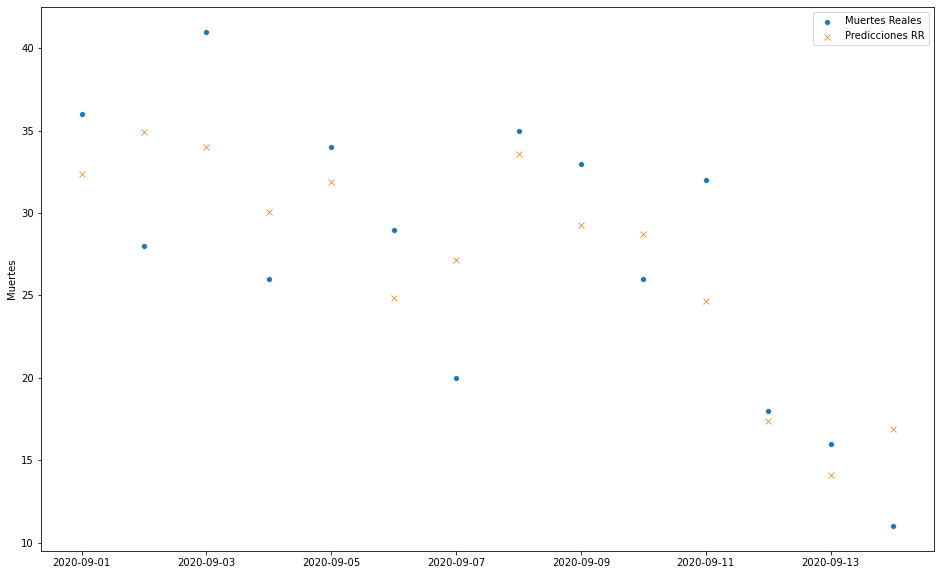

In [41]:
plt.figure(figsize=(16,10))
sns.scatterplot(x, ytest)
sns.scatterplot(x, ypreds['RR MA'], marker='x')
#sns.scatterplot(x, ypreds['KNR MA'])
plt.legend(['Muertes Reales', 'Predicciones RR', 'Predicciones KNR MA'])
plt.ylabel('Muertes')
plt.show()